<a href="https://colab.research.google.com/github/chaimoma/SmartGridBrief/blob/main/Lstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
uploaded=files.upload()
import pandas as pd
import io
df=pd.read_csv(io.BytesIO(uploaded['data.csv']))

Saving data.csv to data.csv


In [ ]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

#convert and sort
df['DateTime']=pd.to_datetime(df['DateTime'])
df = df.sort_values("DateTime")
df.set_index("DateTime",inplace=True)

***Pourquoi l’ordre temporel est critique ?***

  - Because time series depend on the past.
If you shuffle data, the model sees the future before the past → cheating → fake performance.

  

***Pourquoi on ne mélange pas les données (pas de shuffle)  ?***
      
  Classic split assumes data points are independent.
   Time series are not independent.
   If you shuffle:
  The model trains on future hours
  Tests on past hours
   → data leakage

In [ ]:
#scaling
scaler=MinMaxScaler()
scaledData=scaler.fit_transform(df)

***Why is normalization indispensable in Deep Learning?***

   Normalization ensures all features are on the same scale, improves numerical stability, speeds up convergence, and prevents features with large values from dominating learning.

***Why is MinMaxScaler preferred over StandardScaler for LSTM?***

MinMaxScaler scales data to
[
0
,
1
]
[0,1], which matches the range of LSTM activation functions (tanh, sigmoid) and helps stabilize training on time series data.

In [ ]:
def create_sequences(data, window=24):
    X, y = [], []
    for i in range(window, len(data)):
        X.append(data[i-window:i])
        y.append(data[i, 0])  # Consumption
    return np.array(X), np.array(y)

X, y = create_sequences(scaledData)


***Why does an LSTM expect 3D input?***

Because LSTM processes sequences over time, it needs:

    -samples: number of sequences

    -timesteps: time window (24 hours)

    -features: variables per timestep

***Meaning of (samples, timesteps, features) :***

  Each sample represents one sequence of past observations, each timestep is one hour, and features are consumption and energy sources.

In [ ]:
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]


***Why not use a classic train_test_split?***

Classic splitting randomly mixes data, which is invalid for time series and leads to training on future information.

***Risk of temporal data leakage :***

Temporal leakage occurs when future data is used during training, causing overly optimistic evaluation results.

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input

model = Sequential([
    Input(shape=(24, X.shape[2])),
    LSTM(64),
    Dropout(0.2),
    Dense(1)
])

model.compile(optimizer="adam", loss="mse")


***Impact of the number of LSTM units :***

More units increase the model’s capacity to learn complex patterns but also raise the risk of overfitting and longer training time.

***Difference between one and multiple LSTM layers :***

One LSTM layer captures simple temporal patterns

Multiple layers capture more complex dependencies but require more data and regularization

In [ ]:
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=30,
    batch_size=32,
    verbose=2
)

Epoch 1/30
1083/1083 - 10s - 9ms/step - loss: 0.0077 - val_loss: 0.0015
Epoch 2/30
1083/1083 - 7s - 6ms/step - loss: 0.0026 - val_loss: 0.0011
Epoch 3/30
1083/1083 - 6s - 6ms/step - loss: 0.0019 - val_loss: 7.2675e-04
Epoch 4/30
1083/1083 - 5s - 5ms/step - loss: 0.0014 - val_loss: 6.2804e-04
Epoch 5/30
1083/1083 - 6s - 6ms/step - loss: 0.0011 - val_loss: 5.1887e-04
Epoch 6/30
1083/1083 - 5s - 5ms/step - loss: 9.0100e-04 - val_loss: 4.9871e-04
Epoch 7/30
1083/1083 - 6s - 6ms/step - loss: 8.0426e-04 - val_loss: 5.1703e-04
Epoch 8/30
1083/1083 - 5s - 5ms/step - loss: 7.3268e-04 - val_loss: 4.5308e-04
Epoch 9/30
1083/1083 - 6s - 5ms/step - loss: 6.8266e-04 - val_loss: 4.2954e-04
Epoch 10/30
1083/1083 - 5s - 5ms/step - loss: 6.2130e-04 - val_loss: 3.7043e-04
Epoch 11/30
1083/1083 - 5s - 5ms/step - loss: 5.9142e-04 - val_loss: 3.7091e-04
Epoch 12/30
1083/1083 - 6s - 5ms/step - loss: 5.5580e-04 - val_loss: 3.4792e-04
Epoch 13/30
1083/1083 - 5s - 5ms/step - loss: 5.3715e-04 - val_loss: 3.4924e

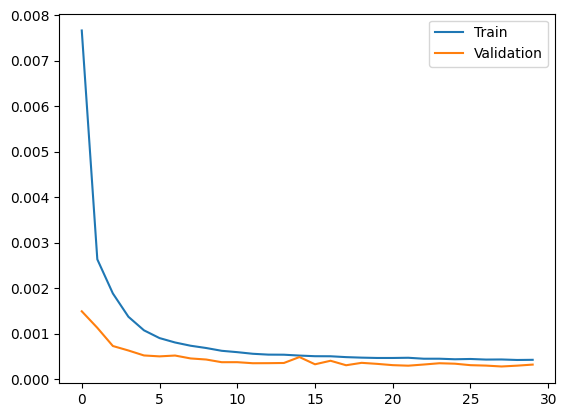

339/339 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


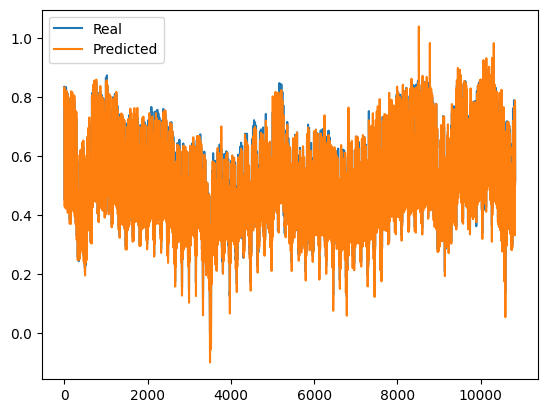

In [ ]:
import matplotlib.pyplot as plt

# Loss curve
plt.plot(history.history["loss"], label="Train")
plt.plot(history.history["val_loss"], label="Validation")
plt.legend()
plt.show()

# Predictions
y_pred = model.predict(X_test)
plt.plot(y_test, label="Real")
plt.plot(y_pred, label="Predicted")
plt.legend()
plt.show()


In [ ]:
model.save("LstmSmartGrid.keras")